(sec-tutorial-ops-qubits)=

# Tutorial: Operations and Qubits

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Operations and Qubits.ipynb`
```

## Gates, measurements and qubits

In the previous tutorials, experiments were created on the {ref}`quantum-device level<sec-user-guide-quantum-device>`. On this level,
operations are defined in terms of explicit signals and locations on chip, rather than the qubit and the intended operation.
To allow working at a greater level of abstraction, `quantify_scheduler` allows creating operations on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>`.
Instead of signals, clocks, and ports, operations are defined by the the effect they have on specific qubits. This representation of the schedules can be compiled to the quantum-device level to create the pulse schemes.

In this tutorial we show how to define operations on the {ref}`quantum-circuit level<sec-user-guide-quantum-circuit>`, combine them into schedules, and show their circuit-level visualization.
We go through the configuration file needed to compile the schedule to the quantum-device level and show how these configuration files can be created automatically and dynamically.
Finally, we showcase the hybrid nature of `quantify_scheduler`, allowing the scheduling circuit-level and device-level operations side by side in the same schedule.

Many of the gates used in the circuit layer description are defined in
{class}`~quantify_scheduler.operations.gate_library` such as {class}`~quantify_scheduler.operations.gate_library.Reset`, {class}`~quantify_scheduler.operations.gate_library.X90` and
{class}`~quantify_scheduler.operations.gate_library.Measure`.
Operations are instantiated by providing them with the name of the qubit(s) on which
they operate:

In [1]:
from quantify_scheduler.operations.gate_library import CZ, Measure, Reset, X90

q0, q1 = ("q0", "q1")
X90(q0)
Measure(q1)
CZ(q0, q1)
Reset(q0)



{'name': 'Reset q0', 'gate_info': {'unitary': None, 'tex': '$|0\\rangle$', 'plot_func': 'quantify_scheduler.visualization.circuit_diagram.reset', 'qubits': ['q0'], 'operation_type': 'reset'}, 'pulse_info': [], 'acquisition_info': [], 'logic_info': {}}

Let's investigate the different components present in the circuit-level description of
the operation. As an example, we create a 45 degree rotation operation over the
x-axis.

In [2]:
from pprint import pprint
from quantify_scheduler.operations.gate_library import Rxy

rxy45 = Rxy(theta=45.0, phi=0.0, qubit=q0)
pprint(rxy45.data)



{'acquisition_info': [],
 'gate_info': {'operation_type': 'Rxy',
               'phi': 0.0,
               'plot_func': 'quantify_scheduler.visualization.circuit_diagram.gate_box',
               'qubits': ['q0'],
               'tex': '$R_{xy}^{45, 0}$',
               'theta': 45.0,
               'unitary': array([[0.92387953+0.j        , 0.        -0.38268343j],
       [0.        -0.38268343j, 0.92387953+0.j        ]])},
 'logic_info': {},
 'name': "Rxy(45, 0, 'q0')",
 'pulse_info': []}


As we can see, the structure of a circuit-level operation is similar to a pulse-level
operation. However, the information is contained inside the {code}`gate_info` entry rather
than the {code}`pulse_info` entry of the data dictionary.
Importantly, there is no device-specific information coupled to the operation such that
it represents the abstract notion of this qubit rotation, rather than how to perform it
on any physical qubit implementation.

The entries present above are documented in the `operation` schema.
Generally, these schemas are only important when defining custom operations, which is
not part of this tutorial. This schema can be inspected via:

In [3]:
import importlib.resources
import json
from quantify_scheduler import schemas

operation_schema = json.loads(importlib.resources.read_text(schemas, "operation.json"))
pprint(operation_schema["properties"]["gate_info"]["properties"])



{'operation_type': {'description': 'Defines what class of operations this gate '
                                   'refers to (e.g. Rxy, CZ etc.).',
                    'type': 'string'},
 'plot_func': {'description': 'reference to a function for plotting this '
                              'operation. If not specified, defaults to using '
                              ':func:`~quantify_scheduler.visualization.circuit_diagram.gate_box`.',
               'type': ['string', 'null']},
 'qubits': {'description': 'A list of strings indicating the qubits the gate '
                           'acts on. Valid qubits are strings that appear in '
                           'the device_config.json file.',
            'type': 'array'},
 'symmetric': {'description': 'A boolean to indicate whether a two qubit gate '
                              'is symmetric. This is used in the device config '
                              'compilation stage. By default, it is set as '
                          

## Schedule creation from the circuit layer (Bell)

The circuit-level operations can be used to create a `schedule` within
`quantify_scheduler` using the same method as for the pulse-level operations.
This enables creating schedules on a more abstract level.
We exemplify this extra layer of abstraction by creating a `schedule` for measuring
`Bell violations`.

```{note}
Within a single `schedule`, high-level circuit layer operations can be mixed with quantum-device level operations. This mixed representation is useful for experiments where some pulses cannot easily be represented as qubit gates. An example of this is given by the `Chevron` experiment given in {ref}`Mixing pulse and circuit layer operations (Chevron)`.
```

As the first example, we want to create a schedule for performing the
[Bell experiment](https://en.wikipedia.org/wiki/Bell%27s_theorem).
The goal of the Bell experiment is to create a Bell state
{math}`|\Phi ^+\rangle=\frac{1}{2}(|00\rangle+|11\rangle)` which is a perfectly entangled state, followed by a measurement.
By rotating the measurement basis, or equivalently one of the qubits, it is possible
to observe violations of the CSHS inequality.

We create this experiment using the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>` description.
This allows defining the Bell schedule as:

In [4]:
import numpy as np
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import CZ, Measure, Reset, Rxy, X90

sched = Schedule("Bell experiment")

for acq_idx, theta in enumerate(np.linspace(0, 360, 21)):
    sched.add(Reset(q0, q1))
    sched.add(X90(q0))
    sched.add(X90(q1), ref_pt="start")  # Start at the same time as the other X90
    sched.add(CZ(q0, q1))
    sched.add(Rxy(theta=theta, phi=0, qubit=q0))

    sched.add(Measure(q0, acq_index=acq_idx), label="M q0 {:.2f} deg".format(theta))
    sched.add(  # Start at the same time as the other measure
        Measure(q1, acq_index=acq_idx),
        label="M q1 {:.2f} deg".format(theta),
        ref_pt="start",
    )

sched



Schedule "Bell experiment" containing (66) 147  (unique) operations.

By scheduling 7 operations for 21 different values for {code}`theta` we indeed get a schedule containing 7\*21=147 operations. To minimize the size of the schedule, identical operations are stored only once. For example, the {class}`~quantify_scheduler.operations.gate_library.CZ` operation is stored only once but used 21 times, which leaves only 66 unique operations in the schedule.

```{note}
The acquisitions are different for every iteration due to their different {code}`acq_index`. The {class}`~quantify_scheduler.operations.gate_library.Rxy`-gate rotates over a different angle every iteration and must therefore also be different for every iteration (except for the last since {math}`R^{360}=R^0`). Hence the number of unique operations is 3\*21-1+4=66.
```

## Visualizing the quantum circuit

We can directly visualize the created schedule on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>`.
This visualization shows every operation on a line representing the different qubits.

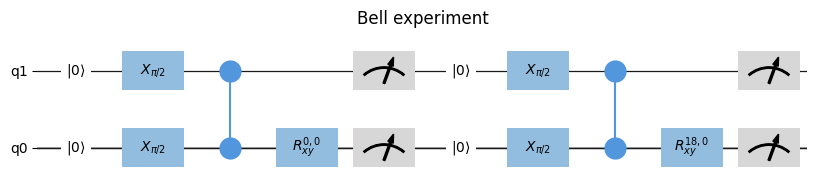

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

_, ax = sched.plot_circuit_diagram()
# all gates are plotted, but it doesn't all fit in a matplotlib figure.
# Therefore we use :code:`set_xlim` to limit the number of gates shown.
ax.set_xlim(-0.5, 9.5)
plt.show()



In previous tutorials, we visualized the `schedules` on the pulse level using {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` .
Up until now, however, all gates have been defined on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>` without defining the
corresponding pulse shapes.
Therefore, trying to run {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` will raise an error which
signifies no {code}`pulse_info` is present in the schedule:

In [6]:
sched.plot_pulse_diagram()


RuntimeError: Attempting to sample schedule Bell experiment, but the schedule does not contain any `pulse_info`. Please verify that the schedule has been populated and device compilation has been performed.

And similarly for the {code}`timing_table`:

In [7]:
sched.timing_table


ValueError: Absolute time has not been determined yet.

## Device configuration

Up until now the schedule is not specific to any qubit implementation.
The aim of this section is to add device specific information to the schedule.
This knowledge is contained in the {ref}`device configuration<sec-device-config>`, which we introduce in this section.
By compiling the schedule to the quantum-device layer, we incorporate the device configuration into the schedule (for example by adding pulse information to every gate) and thereby enable it to run on a specific qubit implementation.

To start this section, we will unpack the structure of the device configuration.
Here we will use an example device configuration for a transmon-based system that is used in the
`quantify-scheduler` test suite.

In [8]:
from quantify_scheduler.backends.circuit_to_device import DeviceCompilationConfig
from quantify_scheduler.schemas.examples.circuit_to_device_example_cfgs import (
    example_transmon_cfg,
)

device_cfg = DeviceCompilationConfig.parse_obj(example_transmon_cfg)

list(device_cfg.dict())



['backend', 'clocks', 'elements', 'edges']

Before explaining how this can be used to compile schedules, let us first investigate
the contents of the device configuration.

In [9]:
device_cfg.backend



'quantify_scheduler.backends.circuit_to_device.compile_circuit_to_device'

The backend of the device configuration specifies what function will be used to add
pulse information to the gates. In other words, it specifies how to interpret the
qubit parameters present in the device configuration and achieve the required gates.
Let us briefly investigate the backend function:

In [10]:
from quantify_scheduler.helpers.importers import import_python_object_from_string

help(import_python_object_from_string(device_cfg.backend))



Help on function compile_circuit_to_device in module quantify_scheduler.backends.circuit_to_device:

compile_circuit_to_device(schedule: quantify_scheduler.schedules.schedule.Schedule, device_cfg: Union[quantify_scheduler.backends.circuit_to_device.DeviceCompilationConfig, dict, NoneType] = None) -> quantify_scheduler.schedules.schedule.Schedule
    Adds the information required to represent operations on the quantum-device
    abstraction layer to operations that contain information on how to be represented
    on the quantum-circuit layer.
    
    Parameters
    ----------
    schedule
        The schedule to be compiled.
    device_cfg
        Device specific configuration, defines the compilation step from
        the quantum-circuit layer to the quantum-device layer description.
        Note, if a dictionary is passed, it will be parsed to a
        :class:`~DeviceCompilationConfig`.



The {ref}`device configuration <sec-device-config>` also contains the
parameters required by the backend for all qubits and edges.

In [11]:
print(list(device_cfg.elements))
print(list(device_cfg.edges))
print(list(device_cfg.clocks))



['q0', 'q1']
['q0_q1']
['q0.01', 'q0.ro', 'q1.01', 'q1.ro']


For every qubit and edge we can investigate the contained parameters.

In [12]:
print(device_cfg.elements["q0"])
print(device_cfg.elements["q0"]["Rxy"].factory_kwargs)



{'reset': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_library.IdlePulse', factory_kwargs={'duration': 0.0002}, gate_info_factory_kwargs=None), 'Rxy': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_factories.rxy_drag_pulse', factory_kwargs={'amp180': 0.32, 'motzoi': 0.45, 'port': 'q0:mw', 'clock': 'q0.01', 'duration': 2e-08}, gate_info_factory_kwargs=['theta', 'phi']), 'Z': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_library.SoftSquarePulse', factory_kwargs={'amp': 0.23, 'duration': 4e-09, 'port': 'q0:fl', 'clock': 'cl0.baseband'}, gate_info_factory_kwargs=None), 'measure': OperationCompilationConfig(factory_func='quantify_scheduler.operations.measurement_factories.dispersive_measurement', factory_kwargs={'port': 'q0:res', 'clock': 'q0.ro', 'pulse_type': 'SquarePulse', 'pulse_amp': 0.25, 'pulse_duration': 1.6e-07, 'acq_delay': 1.2e-07, 'acq_duration': 3e-07, 'acq_channel': 0}, gate_info_facto

In [13]:
print(device_cfg.edges)



{'q0_q1': {'CZ': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_factories.composite_square_pulse', factory_kwargs={'square_port': 'q0:fl', 'square_clock': 'cl0.baseband', 'square_amp': 0.5, 'square_duration': 2e-08, 'virt_z_parent_qubit_phase': 44, 'virt_z_parent_qubit_clock': 'q0.01', 'virt_z_child_qubit_phase': 63, 'virt_z_child_qubit_clock': 'q1.01'}, gate_info_factory_kwargs=None)}}


In [14]:
print(device_cfg.clocks)




{'q0.01': 6020000000.0, 'q0.ro': 7040000000.0, 'q1.01': 5020000000.0, 'q1.ro': 6900000000.0}


Lastly, the complete example device configuration (also see {class}`~quantify_scheduler.backends.circuit_to_device.DeviceCompilationConfig`):

In [15]:
pprint(example_transmon_cfg)



{'backend': 'quantify_scheduler.backends.circuit_to_device.compile_circuit_to_device',
 'clocks': {'q0.01': 6020000000.0,
            'q0.ro': 7040000000.0,
            'q1.01': 5020000000.0,
            'q1.ro': 6900000000.0},
 'edges': {'q0_q1': {'CZ': {'factory_func': 'quantify_scheduler.operations.pulse_factories.composite_square_pulse',
                            'factory_kwargs': {'square_amp': 0.5,
                                               'square_clock': 'cl0.baseband',
                                               'square_duration': 2e-08,
                                               'square_port': 'q0:fl',
                                               'virt_z_child_qubit_clock': 'q1.01',
                                               'virt_z_child_qubit_phase': 63,
                                               'virt_z_parent_qubit_clock': 'q0.01',
                                               'virt_z_parent_qubit_phase': 44}}}},
 'elements': {'q0': {'Rxy': {'facto

### Device compilation

Now that we went through the different components of the configuration file, let's use
it to compile our previously defined schedule.
The {func}`~quantify_scheduler.compilation.device_compile` function takes care of this task and adds pulse information based
on the configuration file, as discussed above.
It also determines the timing of the different pulses in the schedule. Also see {ref}`Device and Hardware compilation combined`.

In [16]:
from quantify_scheduler.compilation import device_compile

pulse_sched = device_compile(sched, device_cfg)



/tmp/ipykernel_23766/657737765.py:3: FutureWarning: Function quantify_scheduler.compilation.device_compile() is deprecated and will be removed in quantify-scheduler-0.9.0. Use the `QuantifyCompiler.compile` method instead. See the user guide section on compilers for details.
  pulse_sched = device_compile(sched, device_cfg)


Now that the timings have been determined, we can show the first few rows of the {code}`timing_table`:

In [17]:
pulse_sched.timing_table.hide(slice(11, None), axis="index").hide(
    "waveform_op_id", axis="columns"
)



And since all pulse information has been determined, we can show the pulse diagram as
well:

(0.0004005, 0.0004006)

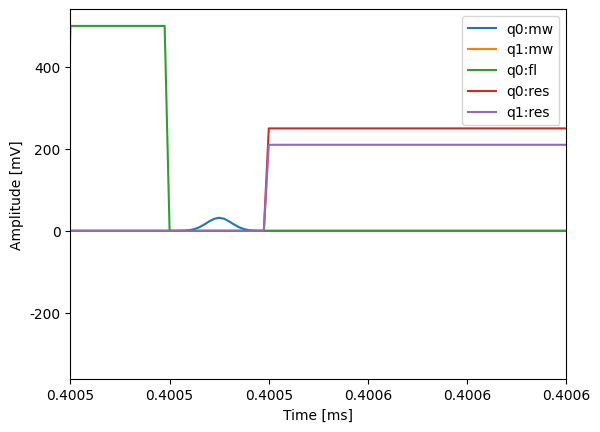

In [18]:
f, ax = pulse_sched.plot_pulse_diagram()
ax.set_xlim(0.4005e-3, 0.4006e-3)



## Quantum Devices and Elements

The {ref}`device configuration<sec-device-config>` contains all knowledge
of the physical device under test (DUT).
To generate these device configurations on the fly, `quantify_scheduler` provides the
{class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` and
{class}`~quantify_scheduler.device_under_test.device_element.DeviceElement` classes.

These classes contain the information necessary to generate the device configs and allow
changing their parameters on-the-fly.
The {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` class
represents the DUT containing different {class}`~quantify_scheduler.device_under_test.device_element.DeviceElement` s.
Currently, `quantify_scheduler` contains the
{class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` class
to represent a fixed-frequency transmon qubit connected to a feedline. We show their interaction below:

In [19]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

# First create a device under test
dut = QuantumDevice("DUT")

# Then create a transmon element
qubit = BasicTransmonElement("qubit")

# Finally, add the transmon element to the QuantumDevice
dut.add_element(qubit)
dut, dut.elements()



(<QuantumDevice: DUT>, ['qubit'])

The different transmon properties can be set through attributes of the {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` class instance, e.g.:

In [20]:
qubit.clock_freqs.f01(6e9)

print(list(qubit.submodules.keys()))
print()
for submodule_name, submodule in qubit.submodules.items():
    print(f"{qubit.name}.{submodule_name}: {list(submodule.parameters.keys())}")



['reset', 'rxy', 'measure', 'ports', 'clock_freqs']

qubit.reset: ['duration']
qubit.rxy: ['amp180', 'motzoi', 'duration']
qubit.measure: ['pulse_type', 'pulse_amp', 'pulse_duration', 'acq_channel', 'acq_delay', 'integration_time', 'reset_clock_phase', 'acq_weight_type']
qubit.ports: ['microwave', 'flux', 'readout']
qubit.clock_freqs: ['f01', 'f12', 'readout']


The device configuration is now simply obtained using {code}`dut.generate_device_config()`.
In order for this command to provide a correct device configuration, the different
parameters need to be specified in the {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` and {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` objects.

In [21]:
pprint(dut.generate_device_config())



DeviceCompilationConfig(backend='quantify_scheduler.backends.circuit_to_device.compile_circuit_to_device', clocks={'qubit.01': 6000000000.0, 'qubit.12': nan, 'qubit.ro': nan}, elements={'qubit': {'reset': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_library.IdlePulse', factory_kwargs={'duration': 0.0002}, gate_info_factory_kwargs=None), 'Rxy': OperationCompilationConfig(factory_func='quantify_scheduler.operations.pulse_factories.rxy_drag_pulse', factory_kwargs={'amp180': nan, 'motzoi': 0, 'port': 'qubit:mw', 'clock': 'qubit.01', 'duration': 2e-08}, gate_info_factory_kwargs=['theta', 'phi']), 'measure': OperationCompilationConfig(factory_func='quantify_scheduler.operations.measurement_factories.dispersive_measurement', factory_kwargs={'port': 'qubit:res', 'clock': 'qubit.ro', 'pulse_type': 'SquarePulse', 'pulse_amp': 0.25, 'pulse_duration': 3e-07, 'acq_delay': 0, 'acq_duration': 1e-06, 'acq_channel': 0, 'acq_protocol_default': 'SSBIntegrationComplex', 're

## Mixing pulse and circuit layer operations (Chevron)

As well as defining our schedules in terms of gates, we can also mix the circuit layer
representation with pulse-level operations.
This can be useful for experiments involving pulses not easily represented by Gates,
such as the Chevron experiment.
In this experiment, we want to vary the length and amplitude of a square pulse between
X gates on a pair of qubits.

In [22]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import Measure, Reset, X, X90
from quantify_scheduler.operations.pulse_library import SquarePulse
from quantify_scheduler.resources import ClockResource

sched = Schedule("Chevron Experiment")
acq_idx = 0

# Multiples of 4 ns need to be used due to sampling rate of the Qblox modules
for duration in np.linspace(start=20e-9, stop=60e-9, num=6):
    for amp in np.linspace(start=0.1, stop=1.0, num=10):
        reset = sched.add(Reset("q0", "q1"))
        sched.add(X("q0"), ref_op=reset, ref_pt="end")  # Start at the end of the reset
        # We specify a clock for tutorial purposes, Chevron experiments do not necessarily use modulated square pulses
        square = sched.add(SquarePulse(amp, duration, "q0:mw", clock="q0.01"))
        sched.add(X90("q0"), ref_op=square)  # Start at the end of the square pulse
        sched.add(X90("q1"), ref_op=square)
        sched.add(Measure(q0, acq_index=acq_idx), label=f"M q0 {acq_idx}")
        sched.add(  # Start at the same time as the other measure
            Measure(q1, acq_index=acq_idx),
            label=f"M q1 {acq_idx}",
            ref_pt="start",
        )

        acq_idx += 1
        
# Manually add the clocks
sched.add_resources([ClockResource("q0.01", 6.02e9), ClockResource("q0.ro", 4.2e9), ClockResource("q1.01", 6.02e9), ClockResource("q1.ro", 4.2e9)])



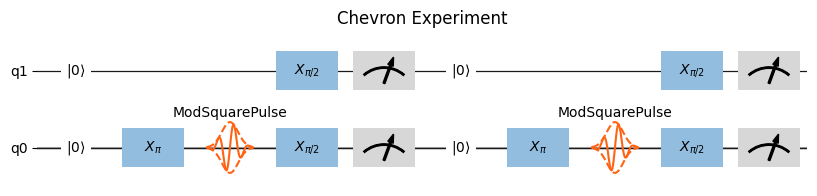

In [23]:
fig, ax = sched.plot_circuit_diagram()
ax.set_xlim(-0.5, 9.5)
for t in ax.texts:
    if t.get_position()[0] > 9.5:
        t.set_visible(False)



This example shows that we add gates using the same interface as pulses. Gates are Operations, and
as such support the same timing and reference operators as Pulses.

```{warning}
When adding a Pulse to a schedule, the clock is not automatically added to the
resources of the schedule. It may be necessary to add this clock manually, as in
the final line of the example above.
```

### Device and Hardware compilation combined

Rather than first using {func}`~quantify_scheduler.compilation.device_compile` and subsequently
{func}`~quantify_scheduler.compilation.hardware_compile`, the two function calls can be combined using
{func}`~quantify_scheduler.compilation.qcompile`.

In [24]:
from quantify_scheduler.compilation import qcompile
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

dut.close()
dut = QuantumDevice("DUT")
q0 = BasicTransmonElement("q0")
q1 = BasicTransmonElement("q1")
dut.add_element(q0)
dut.add_element(q1)
dut.get_element("q0").rxy.amp180(0.6)
dut.get_element("q1").rxy.amp180(0.6)

compiled_sched = qcompile(
    schedule=sched, device_cfg=dut.generate_device_config(), hardware_cfg=None
)



/tmp/ipykernel_23766/652173263.py:14: FutureWarning: Function quantify_scheduler.compilation.qcompile() is deprecated and will be removed in quantify-scheduler-0.9.0. Use the `QuantifyCompiler.compile` method instead. See the user guide section on compilers for details.
  compiled_sched = qcompile(


So, finally, we can show the timing table associated to the chevron schedule and plot
its pulse diagram:

In [25]:
compiled_sched.timing_table.hide(slice(11, None), axis="index").hide(
    "waveform_op_id", axis="columns"
)



(0.0002, 0.0002004)

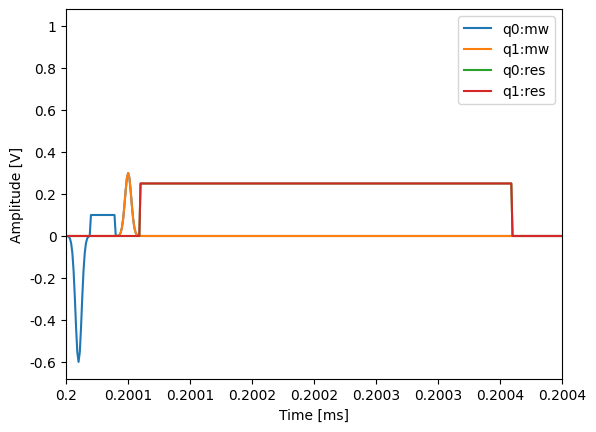

In [26]:
f, ax = compiled_sched.plot_pulse_diagram()
ax.set_xlim(200e-6, 200.4e-6)